In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 1)
y_test shape: (10000, 1)


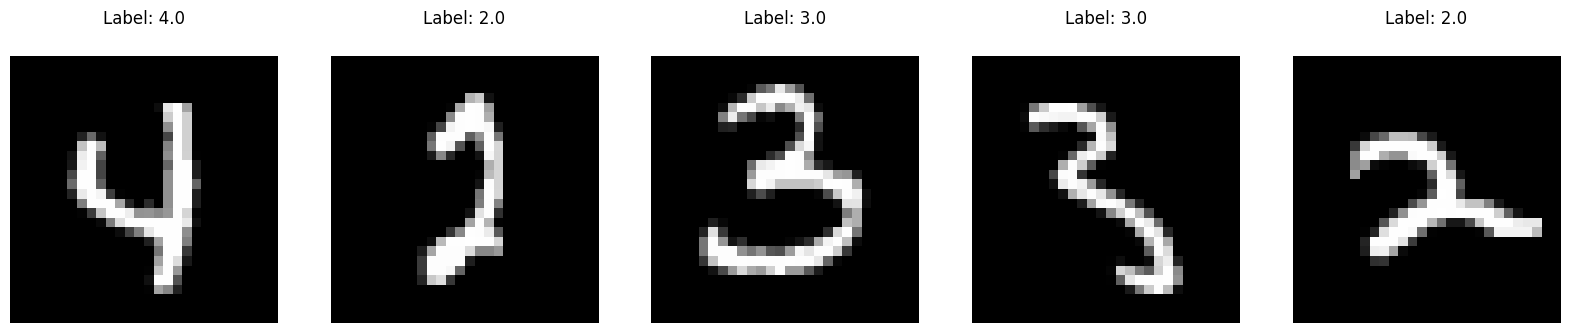

In [18]:
with np.load('../lab3/mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k].astype('float32') for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
x_train = np.array(x_train)[:,:,:, np.newaxis]
x_test = np.array(x_test)[:,:,:, np.newaxis]

y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import keras_tuner as kt

def build_model(hp):
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_dense_layers = hp.Int('dense_layers', min_value=1, max_value=10, step=1)
    hp_conv_layers = hp.Int('conv_layers', min_value=1, max_value=2)
    hp_learning_rate = hp.Float(
      'learning_rate',
      min_value=1e-6,
      max_value=1e-2,
      sampling='LOG',
      default=1e-3
    )
    
    model = Sequential()
    
    model.add(Conv2D(hp_filters, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(hp_conv_layers):
      model.add(Conv2D(hp_filters * (2 ** (i + 1)), (3, 3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))
      
    model.add(GlobalAveragePooling2D())
       
    for i in range(hp_dense_layers):
      model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=2048, step=32), activation='relu'))
      model.add(Dropout(rate=hp.Float(
        f'dropout_rate_{i}',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
      )))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                    loss=SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tmp',
                     project_name='mnist_MLP')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train, y_train, epochs=500, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Найкращі параметри:\n")
print(best_hps.values)

Trial 23 Complete [00h 01m 17s]
val_accuracy: 0.9115833044052124

Best val_accuracy So Far: 0.9872499704360962
Total elapsed time: 00h 12m 56s
Найкращі параметри:

{'filters': 128, 'dense_layers': 1, 'conv_layers': 2, 'learning_rate': 0.00023821341615471963, 'units_0': 160, 'dropout_rate_0': 0.15000000000000002, 'units_1': 800, 'dropout_rate_1': 0.2, 'units_2': 992, 'dropout_rate_2': 0.05, 'units_3': 576, 'dropout_rate_3': 0.30000000000000004, 'units_4': 576, 'dropout_rate_4': 0.45, 'units_5': 1120, 'dropout_rate_5': 0.2, 'units_6': 1120, 'dropout_rate_6': 0.35000000000000003, 'units_7': 1920, 'dropout_rate_7': 0.35000000000000003, 'units_8': 512, 'dropout_rate_8': 0.4, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0017'}


In [20]:
hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8616 - loss: 0.7444 - val_accuracy: 0.9753 - val_loss: 0.0812
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9729 - loss: 0.0898 - val_accuracy: 0.9806 - val_loss: 0.0669
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9834 - loss: 0.0547 - val_accuracy: 0.9823 - val_loss: 0.0613
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9892 - loss: 0.0362 - val_accuracy: 0.9857 - val_loss: 0.0495
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9910 - loss: 0.0294 - val_accuracy: 0.9875 - val_loss: 0.0465
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9927 - loss: 0.0232 - val_accuracy: 0.9847 - val_loss: 0.0593
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9931 - loss: 0.0209 - val_accuracy: 0.9900 - val_loss: 0.0395
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9949 - loss: 0.0148 - 

In [21]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[Loss, Accuracy]:", eval_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.1759
[Loss, Accuracy]: [0.1375879943370819, 0.9904999732971191]


In [22]:
predictions = hypermodel.predict(x_test).argmax(axis=1)

predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

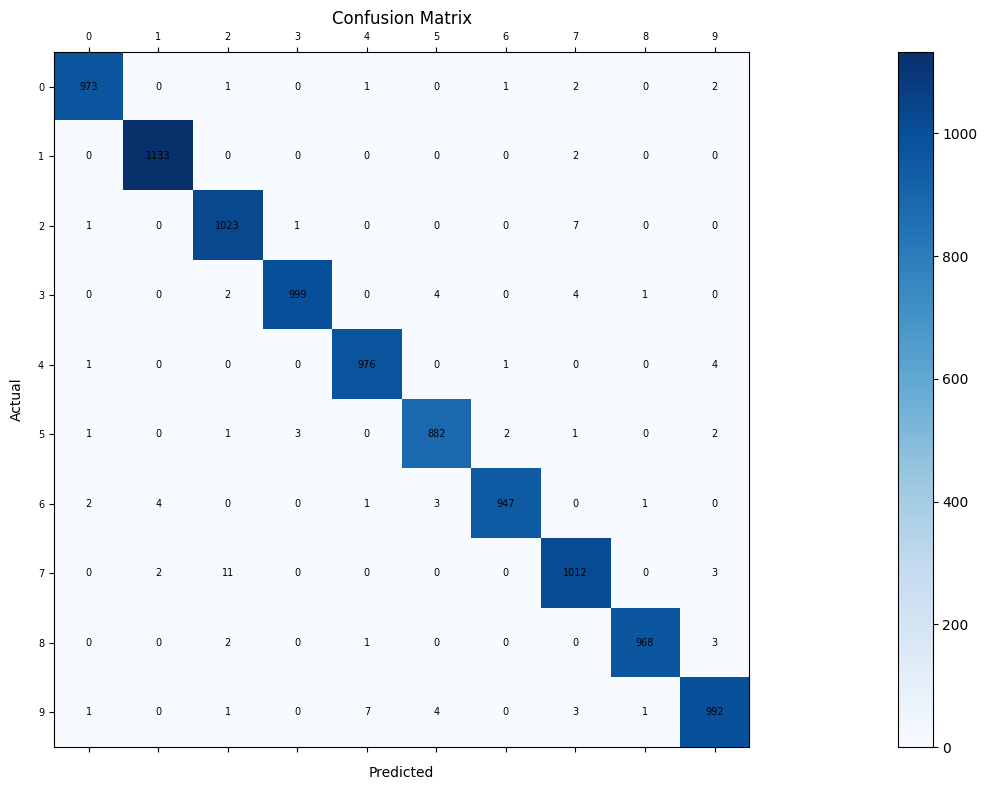

In [23]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(30, 8))
cax = ax.matshow(conf_matrix, cmap="Blues")

plt.colorbar(cax)

class_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=7)
ax.set_yticklabels(class_labels, fontsize=7)

plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted", labelpad=10)
plt.ylabel("Actual", labelpad=10)

for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=7)

plt.tight_layout()
plt.show()